In [1]:
import pandas as pd
df_ml = pd.read_csv("../data/processed/FalabellaAyuda_2022-12-27.csv")
df_ml.dropna(subset=["tweet_text"], inplace=True)
# df_ml = df_ml[df_ml["sentiment"] != "others"]
df_ml["longitud_text"] = df_ml["tweet_text"].apply(len)
df_ml = df_ml[df_ml["longitud_text"] > 79.0]
df_ml = df_ml.sample(n=100, random_state=42)
df_ml.shape

(100, 9)

In [2]:
def df_to_list(df):
    texts = df["tweet_text"]
    data = []
    for text in texts:
        data.append(text)
    return data

In [3]:
import numpy as np
import torch
from transformers import BertModel, BertTokenizer
tokenizer_español = BertTokenizer.from_pretrained("../pytorch/", do_lower_case=False)
model = BertModel.from_pretrained("../pytorch")

Some weights of the model checkpoint at ../pytorch were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from src import Features
inputs = df_to_list(df_ml)
inputs = Features.bert_encoder(inputs, tokenizer_español)
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [5]:
max_poll = Features.max_polling(last_hidden_states)
mean_poll = Features.mean_polling(last_hidden_states)

In [6]:
data_ml = {
        "Beto+maxPolling+stdN": Features.std_normalization(max_poll),
        "Beto+maxPolling+zScore": Features.z_score_normalization(max_poll),
        "Beto+maxPolling+minMax": Features.min_max_normalization(max_poll),
        "Beto+meanPolling+stdN": Features.std_normalization(mean_poll),
        "Beto+meanPolling+zScore": Features.z_score_normalization(mean_poll),
        "Beto+meanPolling+minMax": Features.min_max_normalization(mean_poll),
    }

In [7]:
def find_indexs(list, value):
    list_aux = list.copy()
    output = []
    while True:
        try:
            index = list_aux.index(value)
            output.append(index)
            list_aux[index] = None
        except ValueError:
            break
    return output

# agrupamiento

In [8]:
import sys

valor_minimo = sys.float_info.min
print(valor_minimo)

2.2250738585072014e-308


# k-means

In [9]:
# k-means
from sklearn.cluster import KMeans
from sklearn import metrics
agrupamiento = {}
metricas = {}
for K in range(2, 8):
    si = []
    vp = []
    for key, value in data_ml.items():
        if key not in metricas:
            metricas[key] = {
                "silhouettes_by_k_centroids": [],
                "VP_by_k_centroids": [],
            }
        # value shape: (77, 768)
        value = np.array(value)
        kmeans = KMeans(
            n_clusters=K,
            init="random",
            max_iter=10000,
            random_state=42,
            n_init=42,
        )
        cluster_labels = kmeans.fit_predict(value)
        centers = kmeans.cluster_centers_
        agrupamiento[key] = list(cluster_labels)
        variances = []
        for k in range(K):
            variance = Features.cluster_variance(value, cluster_labels, centers, k)
            variances.append(variance)
        avg_variance = sum(variances)/len(variances)
        vp.append(avg_variance)
        si.append(metrics.silhouette_score(
            value, kmeans.labels_, metric="sqeuclidean"))
        metricas[key]["silhouettes_by_k_centroids"].append(metrics.silhouette_score(
            value, kmeans.labels_, metric="sqeuclidean"))
        metricas[key]["VP_by_k_centroids"].append(avg_variance)

metricas

{'Beto+maxPolling+stdN': {'silhouettes_by_k_centroids': [0.06987742778617495,
   0.1038285882541915,
   0.005898935856834485,
   0.04574535965005455,
   0.04423257572994295,
   -0.010294848941051435],
  'VP_by_k_centroids': [1.8100923755756485e-06,
   1.7088212106185915e-06,
   1.5100566430186495e-06,
   9.803156699063764e-07,
   8.307085795814296e-07,
   1.0714797896843853e-06]},
 'Beto+maxPolling+zScore': {'silhouettes_by_k_centroids': [0.03901377819770611,
   0.030522311903035768,
   0.025049820504469383,
   0.017210198355186657,
   0.02126680636154235,
   0.017578596947557864],
  'VP_by_k_centroids': [1.0478170150467543,
   1.034725415434071,
   0.8899359300002336,
   0.9233903628206803,
   0.785807074097768,
   0.6267129482925632]},
 'Beto+maxPolling+minMax': {'silhouettes_by_k_centroids': [0.6176759602135994,
   0.517985025522076,
   0.4353349851495069,
   0.3760835455176923,
   0.3147171810319891,
   0.30282015787968236],
  'VP_by_k_centroids': [0.05110635954043172,
   0.0253841

In [10]:
ops = []
opv = []
print(" & Número de grupos & Medida Silhouette & Medida VP")
for metricas_key in metricas.keys():
    sI = metricas[metricas_key]["silhouettes_by_k_centroids"]
    vP = metricas[metricas_key]["VP_by_k_centroids"]
    idx_optimo = Features.optimo_k(sI, vP)
    ops.append(sI[idx_optimo])
    opv.append(vP[idx_optimo])
    print(f"{metricas_key} & {idx_optimo + 2} & {sI[idx_optimo]:.4f} & {vP[idx_optimo]:.4f}")
op_grouping = list(metricas.keys())[Features.optimo_k(ops, opv)]
# print(list(metricas.keys())[best])
# best = Features.optimo_k(ops, opv)
# op_grouping = f"({ops[best]}, {opv[best]})"
print(f"siMax: {max(ops):.4f}, vMinx: {min(opv):.4f}, op: {op_grouping}")

 & Número de grupos & Medida Silhouette & Medida VP
Beto+maxPolling+stdN & 3 & 0.1038 & 0.0000
Beto+maxPolling+zScore & 7 & 0.0176 & 0.6267
Beto+maxPolling+minMax & 2 & 0.6177 & 0.0511
Beto+meanPolling+stdN & 2 & 0.1607 & 0.0000
Beto+meanPolling+zScore & 7 & 0.0453 & 0.4905
Beto+meanPolling+minMax & 2 & 0.2940 & 0.0021
siMax: 0.6177, vMinx: 0.0000, op: Beto+maxPolling+minMax


# Visualización de los resultados de la metricas para encontrar el k-óptimo.

optimo: 1 , x(optimo): 3, y(optimo): 0.1038285882541915
optimo: 5 , x(optimo): 7, y(optimo): 0.017578596947557864
optimo: 0 , x(optimo): 2, y(optimo): 0.6176759602135994
optimo: 0 , x(optimo): 2, y(optimo): 0.16065657500080618
optimo: 5 , x(optimo): 7, y(optimo): 0.04531612719275416
optimo: 0 , x(optimo): 2, y(optimo): 0.2939572740936017


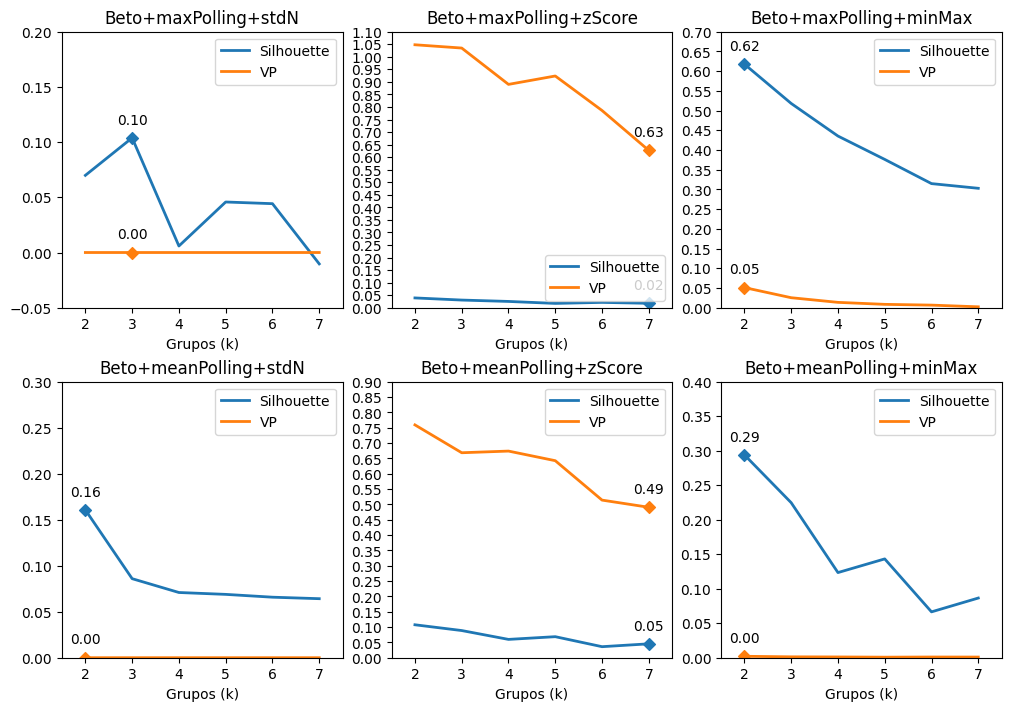

In [11]:
import matplotlib.pyplot as plt
#plt.style.use('_mpl-gallery')
x = range(2, 8)
k_optimos = []
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10, 7),
                        layout="constrained")
for ax, metricas_key in zip(axs.flat, metricas.keys()):
    sI = metricas[metricas_key]["silhouettes_by_k_centroids"]
    vP = metricas[metricas_key]["VP_by_k_centroids"]
    # vP, p = Features.decimal_scaling_normalization(np.array(metricas[metricas_key]["VP_by_k_centroids"]))
    # p = f"/ {p}" if p >= 10 else ""
    optimo = Features.optimo_k(sI, list(vP))
    k_optimos.append(optimo)
    print(f"optimo: {optimo} , x(optimo): {x[optimo]}, y(optimo): {sI[optimo]}")
    # plot

    ax.plot(x, sI, linewidth=2.0, label="Silhouette")
    ax.plot(x, vP, linewidth=2.0, label=f"VP")
    ax.scatter([x[optimo]], [sI[optimo]], marker="D")
    ax.scatter(x[optimo], vP[optimo], marker="D")
    y_max_lim = max([max(vP), max(sI)])
    y_max_lim = round(y_max_lim, 1) + 0.1
    # y_max_lim = 1.0 if y_max_lim >= 1.0 else y_max_lim
    y_min_lim = min([min(vP), min(sI)])
    y_min_lim = round(y_min_lim, 1) - 0.05 if y_min_lim < 0.0 else 0.0
    ax.set(xlim=(x[0] - 0.5, x[-1] + 0.5), xticks=np.arange(x[0], x[-1] + 1),
        ylim=(y_min_lim, y_max_lim), yticks=np.arange(y_min_lim, y_max_lim + 0.05, 0.05))
    ax.set_xlabel("Grupos (k)")

    label0 = "{:.2f}".format(sI[optimo])
    ax.annotate(label0,
                (x[optimo],sI[optimo]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    label1 = "{:.2f}".format(vP[optimo])
    ax.annotate(label1,
                (x[optimo],vP[optimo]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    ax.set_title(f"{metricas_key}")
    ax.legend()
k_optimos = np.array(k_optimos) + 2

plt.show()

# visualización de resultados de analisis de sentimiento en los grupos creados

In [12]:
k_optimos

array([3, 7, 2, 2, 7, 2])

In [13]:
traduccion = {
    "sadness": "tristeza",
    "joy": "alegría",
    "anger": "enojo",
    "surprise": "sorpresa",
    "disgust": "rechazo",
    "Fear": "miedo",
    "others": "otros"
}

In [14]:
i=0
for key, value in data_ml.items():
    kmeans = KMeans(
        n_clusters=k_optimos[i],
        init="random",
        max_iter=10000,
        random_state=42,
        n_init=42,
    ).fit(value)
    agrupamiento[key] = [list(kmeans.labels_), k_optimos[i]]
    i += 1

clusters = {}
for key, value in agrupamiento.items():
    clusters[key] = {}
    for k in range(value[1]):
        clusters[key][f"grupo {k + 1}"] = df_ml.iloc[find_indexs(agrupamiento[key][0], k)]

# preprocesado vs sentimiento.
sentiment_analysis = {}
i=0
for kesI, value0 in clusters.items():
    sentiment_analysis[kesI] = {}
    for kevP, value1 in value0.items():
        sentiment = dict(value1["sentiment"].value_counts())
        sentiment_values = list(sentiment.values())
        sentiment_labels = list(sentiment.keys())
        sentiment_analysis[kesI][kevP] = {f"{traduccion[label]}": value for label, value in zip(sentiment_labels, sentiment_values)}

sentiment_analysis


{'Beto+maxPolling+stdN': {'grupo 1': {'otros': 2, 'tristeza': 1, 'enojo': 1},
  'grupo 2': {'otros': 17, 'enojo': 7, 'tristeza': 2, 'alegría': 1},
  'grupo 3': {'otros': 32, 'enojo': 31, 'tristeza': 5, 'alegría': 1}},
 'Beto+maxPolling+zScore': {'grupo 1': {'otros': 3, 'tristeza': 1},
  'grupo 2': {'enojo': 19, 'otros': 5, 'tristeza': 1},
  'grupo 3': {'otros': 2},
  'grupo 4': {'otros': 2},
  'grupo 5': {'enojo': 3},
  'grupo 6': {'otros': 10, 'enojo': 9, 'tristeza': 2},
  'grupo 7': {'otros': 29, 'enojo': 8, 'tristeza': 4, 'alegría': 2}},
 'Beto+maxPolling+minMax': {'grupo 1': {'otros': 26,
   'enojo': 24,
   'tristeza': 2,
   'alegría': 1},
  'grupo 2': {'otros': 25, 'enojo': 15, 'tristeza': 6, 'alegría': 1}},
 'Beto+meanPolling+stdN': {'grupo 1': {'otros': 15,
   'enojo': 13,
   'tristeza': 3},
  'grupo 2': {'otros': 36, 'enojo': 26, 'tristeza': 5, 'alegría': 2}},
 'Beto+meanPolling+zScore': {'grupo 1': {'otros': 10,
   'enojo': 4,
   'tristeza': 3},
  'grupo 2': {'enojo': 9, 'otro

In [15]:
lst = [[1,2,3], [3,3]]
def colours(lst):
    print(lst)
    outer = []
    inner = []
    outer_colours = [0, 2, 4, 8, 10, 12, 14]
    inner_colours = range(28)
    i0 = 0
    i1 = 0
    for l in lst:
        outer.append(outer_colours[i0])
        for _ in l:
            inner.append(inner_colours[i1])
            i1 += 1
        i0 += 1
        i1 = i0 * 4
    return outer, inner
colours(lst)

[[1, 2, 3], [3, 3]]


([0, 2], [0, 1, 2, 4, 5])

In [16]:
def list_flatten(lst):
    outputs = []
    for l in lst:
        for e in l:
            outputs.append(e)
    return outputs

[[2, 1, 1], [17, 7, 2, 1], [32, 31, 5, 1]]
[[3, 1], [19, 5, 1], [2], [2], [3], [10, 9, 2], [29, 8, 4, 2]]
[[26, 24, 2, 1], [25, 15, 6, 1]]
[[15, 13, 3], [36, 26, 5, 2]]
[[10, 4, 3], [9, 5, 3, 2], [1], [19, 4], [6, 6], [5, 1], [21, 1]]
[[27, 23, 3], [24, 16, 5, 2]]


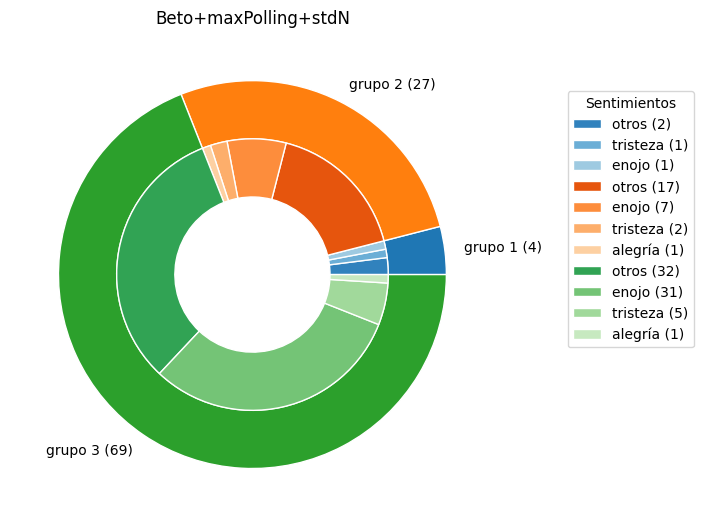

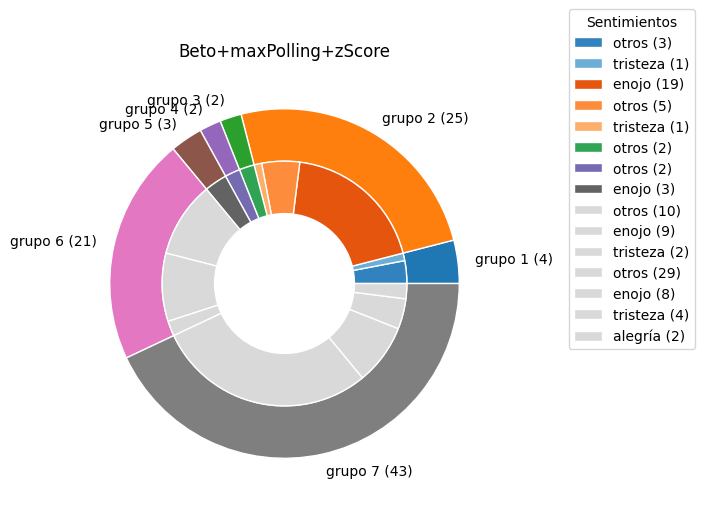

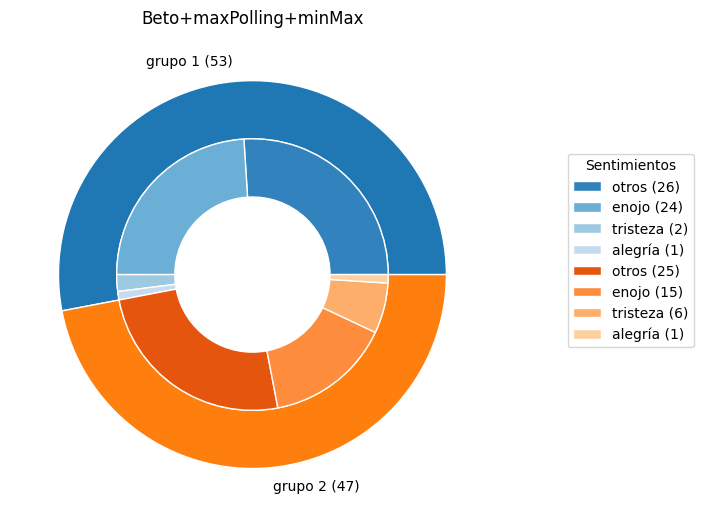

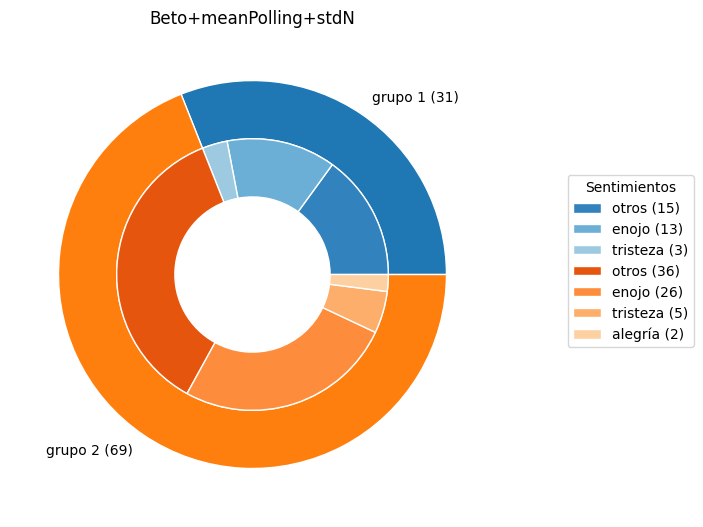

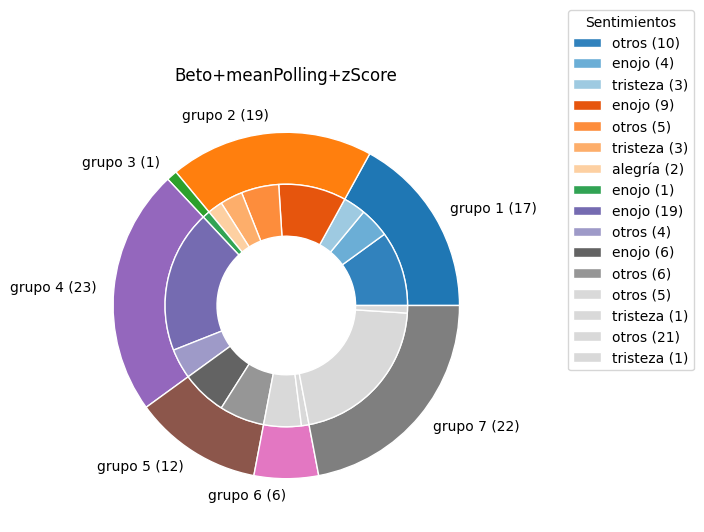

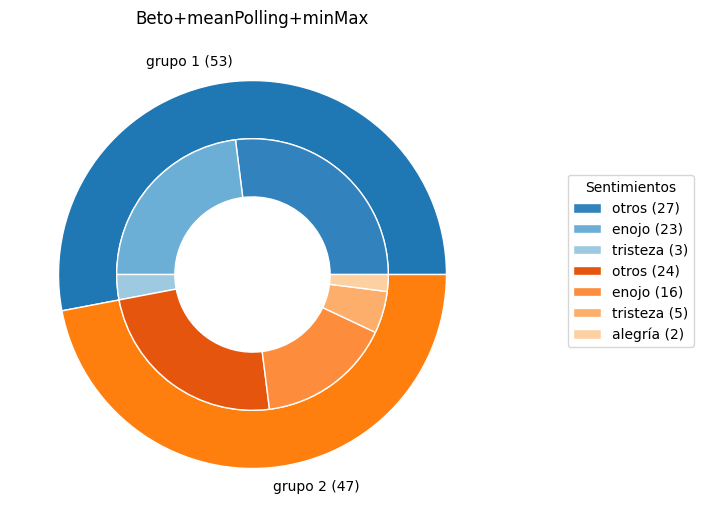

In [17]:
for key in sentiment_analysis.keys():
       fig, ax = plt.subplots(figsize=(7, 6),
                        layout="constrained")
       size = 0.3
       clusters_names = sentiment_analysis[key].keys()
       clusters_sentiments = [list(sentiment_analysis[key][c].keys()) for c in clusters_names]
       clusters_sentiments = list_flatten(clusters_sentiments)
       vals = [list(sentiment_analysis[key][c].values()) for c in clusters_names]
       clusters_names = [f"{c} ({sum(v)})" for c, v in zip(clusters_names, vals)]
       clusters_sentiments = [f"{s} ({v})" for s, v in zip(clusters_sentiments, list_flatten(vals))]

       outer_cmap = plt.get_cmap("tab20")
       inner_cmap = plt.get_cmap("tab20c")
       outer_colors, inner_colors = colours(vals)
       outer_colors = outer_cmap(np.array(outer_colors))
       inner_colors = inner_cmap(np.array(inner_colors))

       sum_vals = [sum(list(i)) for i in vals]
       ax.pie(sum_vals, radius=1, colors=outer_colors, labels=clusters_names,
              wedgeprops=dict(width=size, edgecolor='w'))

       ax.pie(list_flatten(vals), radius=1-size, colors=inner_colors, labels=[" " for _ in clusters_sentiments],
              labeldistance=0.5, wedgeprops=dict(width=size, edgecolor='w'))

       ax.set(aspect="equal", title=f'{key}')
       handles, labels = ax.get_legend_handles_labels()

       ax.legend(handles[len(clusters_names):], clusters_sentiments, loc=(1.15, 0.35), title="Sentimientos")

plt.show()

# Extracción de información

In [18]:
# Example usage
corpus = {}
key_list = list(clusters.keys())
for k in key_list:
    corpus[k] = {}
    for key, value0 in clusters[k].items():
        corpus[k][key] = {
            "text": value0['tweet_text'].tolist(),
            "sentiment": value0['sentiment'].tolist()
        }
        # corpus.append(value0['tweet_text'].tolist())
corpus[op_grouping]

{'grupo 1': {'text': ['no compren en falabella son una estafa uno confia en ellos, a mi el 5 de octubre me descontaron plata sin hacer la compra y hasta el dia de hoy no son capas de devolverme mi dinero hablen un vaso y lo cierran ya no se que hacer, creo q colabore',
   'por que sus vendedores y jefes de los vendedores piensan que son duenos de la sucursal? y ellos de forma unilateral escogen los medios de pago. hoy fui a falabella de vina el cual tengo un gran cupo con cmr y cupo con metodo de pago cheque y....',
   'estoy en plazo de derecho a retracto para cambio de un producto mejor. y no me lo quieren validar estan esperando que pasen los dias. como llevo 1 cama king a la tienda? basta. como pruebo 1 colchon x internet? y mas encima se atrasan en la entrega y se regodean ahora',
   'realice una compra que debia llegar el 13 de diciembre, coloque un reclamo y a la fecha nadie se ha contactado conmigo para una solucion, intento cancelar la compra y no se puede ya que dice que la p

In [19]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# Obtener las stopwords en español
stopwords_es = stopwords.words('spanish')

In [20]:
def concatenar_lista_strings(lista_strings):
    resultado = ""
    for cadena in lista_strings:
        resultado += cadena
    return resultado

In [21]:
from src import Summarize
from sklearn.feature_extraction.text import CountVectorizer
sumarize = Summarize()
vectorizer = CountVectorizer()
# todolos lo procesados
# for k in key_list:
#     tcre_results[k] = {}
#     corpus0 = []
#     cluster_result = []
#     grupo = 0
#     for key, value in corpus[k].items():
#         corpus0 += value
#         cluster_result += [grupo]*len(value)
#         grupo += 1 
#     tcre = sumarize.TCRE(corpus0, cluster_result, vectorizer)
#     for indx, v in enumerate(tcre):
#         tcre_results[k][f"grupo {indx + 1}"] = v[:int(len(v)*0.5)]

# el mejor procesado.
tcre_results = {}
corpus0 = []
cluster_result = []
grupo = 0
As = []
for key, value in corpus[op_grouping].items():
    corpus0 += value["text"]
    cluster_result += [grupo]*len(value["text"])
    grupo += 1
    text = Features.delete_stopwords(value["text"], word_tokenize, stopwords_es)
    A = vectorizer.fit_transform(text).toarray()
    A = A.T
    As.append(A)
tcre = sumarize.TCRE(corpus0, cluster_result, vectorizer)
for indx, v in enumerate(tcre):
    S = vectorizer.fit_transform([concatenar_lista_strings(v[: As[0].shape[0]])]).toarray()
    S = S.T
    S = np.pad(S, [(0, As[indx].shape[0] - S.shape[0]), (0, 0)], mode='constant')
    S = np.pad(S, [(0, 0), (0, As[indx].shape[1] - S.shape[1])], mode='constant')
    tcre_results[f"grupo {indx + 1}"] = {
        "TCRE": v[:int(len(v)*0.3)],
        "main_topic": Summarize.LSA_evaluation_main_topic(
            As[indx],
            S,
        ),
        "term_significance": Summarize.LSA_evaluation_term_significance(
            As[indx],
            S,
        )
    }
tcre_results

{'grupo 1': {'TCRE': ['pesos',
   'octubre',
   'stock',
   'mis',
   'debia',
   '2023',
   'locos',
   'chantas',
   'mint',
   'esten',
   'aca',
   'septiembre',
   'escogen',
   'problemas',
   'sera',
   'indica',
   'pedido',
   'pude',
   'fraude',
   'jo',
   'saldo',
   'llorar',
   'servicio',
   'am',
   'imagino',
   'credito',
   'pagamos',
   'hijo',
   'pregunto',
   'enviado'],
  'main_topic': 0.00507721120833303,
  'term_significance': 0.03286203899503893},
 'grupo 2': {'TCRE': ['cumpleanos',
   'blanca',
   'sistema',
   'vendedores',
   'equipo',
   'nuestra',
   'devuelvanme',
   'desastre',
   'caida',
   'aparece',
   'anulo',
   'si',
   'trozo',
   'nefasto',
   'producto',
   'atencion',
   'credito',
   'del',
   'gestionada',
   'empatia',
   'decir',
   'gris',
   'debio',
   'lunes',
   'confia',
   'telefonicamente',
   'todavia',
   'nos',
   'yo',
   'jamas'],
  'main_topic': -0.011611340123765006,
  'term_significance': 0.033864273073930015}}

In [22]:
# sentences = sent_tokenize(text2)
vectorizer = CountVectorizer()
# A = vectorizer.fit_transform(sentences).toarray()
# A = A.T
# A.shape
lsa_results = {}

for key, value in corpus[op_grouping].items():
    text = Features.delete_stopwords(value["text"], word_tokenize, stopwords_es)
    A = vectorizer.fit_transform(text).toarray()
    A = A.T
    score_indices = Summarize.LSA_summary(A, 3)
    S = Features.delete_stopwords(
        [value["text"][idx] for idx in score_indices],
        word_tokenize,
        stopwords_es,
        )
    S = vectorizer.fit_transform(S).toarray()
    S = S.T
    S = np.pad(S, [(0, A.shape[0] - S.shape[0]), (0, 0)], mode='constant')
    S = np.pad(S, [(0, 0), (0, A.shape[1] - S.shape[1])], mode='constant')
    lsa_results[key] = {
        "Resumen": [value["text"][idx] for idx in score_indices],
        "sentiment": [value["sentiment"][idx] for idx in score_indices],
        "main_topic": Summarize.LSA_evaluation_main_topic(A, S),
        "term_significance": Summarize.LSA_evaluation_term_significance(A, S)
    }

lsa_results

{'grupo 1': {'Resumen': ['realice una compra que debia llegar el 13 de diciembre, coloque un reclamo y a la fecha nadie se ha contactado conmigo para una solucion, intento cancelar la compra y no se puede ya que dice que la prepararon, que espero ahora si ya no quiero la compra?',
   'siendo una devolucion supuestamente gestionada, ya van 5 dias habiles desde que se cancelo la compra, teniendo como plazo 3 dias...pido los comprobantes de devolucion y me dan 4 dias habiles mas para entregarlos',
   'loco laburen se les paga y hagan algo trabajen siempre dicen lo mismo que un ejecutivo se va a contactar y puras mentiras que clase de atencion al cliente pesima empresa no compren mas aca para vender todo bonito pero en post venta" si te he visto no me acuerdo'],
  'sentiment': ['others', 'others', 'anger'],
  'main_topic': -0.1507384614439407,
  'term_significance': 0.29095998214903945},
 'grupo 2': {'Resumen': ['jo jo jo... les he enviado los datos cada vez que me los pedido y sigo espera

In [23]:
from transformers import BertTokenizerFast, EncoderDecoderModel
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt = 'mrm8488/bert2bert_shared-spanish-finetuned-summarization'
tokenizer = BertTokenizerFast.from_pretrained(ckpt)
model = EncoderDecoderModel.from_pretrained(ckpt).to(device)

def generate_summary(text):

   inputs = tokenizer([text], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
   input_ids = inputs.input_ids.to(device)
   attention_mask = inputs.attention_mask.to(device)
   output = model.generate(input_ids, attention_mask=attention_mask)
   return tokenizer.decode(output[0], skip_special_tokens=True)

The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


In [24]:
b2b_results = {}
for key, value in corpus[op_grouping].items():
    text = Features.delete_stopwords(value["text"], word_tokenize, stopwords_es)
    text_concatenated = concatenar_lista_strings(value["text"])
    A = vectorizer.fit_transform(text).toarray()
    A = A.T
    summary = generate_summary(text_concatenated)
    S = sent_tokenize(summary)
    # S = Features.delete_stopwords(
    #     summary,
    #     word_tokenize,
    #     stopwords_es,
    #     )
    S = vectorizer.fit_transform(S).toarray()
    S = S.T
    S = np.pad(S, [(0, A.shape[0] - S.shape[0]), (0, 0)], mode='constant')
    S = np.pad(S, [(0, 0), (0, A.shape[1] - S.shape[1])], mode='constant')
    b2b_results[key] = {
        "Resumen": summary,
        "main_topic": Summarize.LSA_evaluation_main_topic(A, S),
        "term_significance": Summarize.LSA_evaluation_term_significance(A, S)
    }

b2b_results

/home/unknownsystem/Public/tt-pregrado/env_tt/lib/python3.8/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'grupo 1': {'Resumen': 'No se puede esperar que pasen los días. Como si yo no hubiera recibido nada, pero no me lo han pedido',
  'main_topic': 0.06258126386159907,
  'term_significance': 0.14717659664829813},
 'grupo 2': {'Resumen': 'El día 19 me cancelaron la compra. Gracias por arruinar un regalo ahora espero no se haga los locos. Me cancelan la entrega',
  'main_topic': 0.12224692111323857,
  'term_significance': 0.17738381866474556}}

In [25]:
lsa_results_percent = {}

for key, value in corpus[op_grouping].items():
    lsa_results_percent[key] = {}
    rlts1 = ""
    rlts2 = ""
    for i in range(1, 11):
        text = Features.delete_stopwords(value["text"], word_tokenize, stopwords_es)
        A = vectorizer.fit_transform(text).toarray()
        A = A.T
        score_indices = Summarize.LSA_summary(A, int(len(value["text"]) * (i / 10.0)))
        S = Features.delete_stopwords(
            [value["text"][idx] for idx in score_indices],
            word_tokenize,
            stopwords_es,
            )
        S = vectorizer.fit_transform(S).toarray()
        S = S.T
        S = np.pad(S, [(0, A.shape[0] - S.shape[0]), (0, 0)], mode='constant')
        S = np.pad(S, [(0, 0), (0, A.shape[1] - S.shape[1])], mode='constant')
        mt = Summarize.LSA_evaluation_main_topic(A, S)
        ts = Summarize.LSA_evaluation_term_significance(A, S)
        lsa_results_percent[key][f"percent {i * 10}%"] = {
            "main_topic": mt,
            "term_significance": ts
        }
        rlts1 += f"{mt:.2f} & "
        rlts2 += f"{ts:.2f} & "
    print(f"{key} mt: " + rlts1)
    print(f"{key} ts: " + rlts2)

grupo 1 mt: -0.13 & -0.27 & -0.31 & -0.38 & 0.37 & 0.38 & 0.36 & -0.39 & -0.38 & -1.00 & 
grupo 1 ts: 0.37 & 0.53 & 0.63 & 0.71 & 0.76 & 0.80 & 0.80 & 0.83 & 0.84 & 1.00 & 
grupo 2 mt: 0.12 & 0.23 & 0.28 & 0.36 & 0.30 & -0.28 & -0.31 & 0.30 & 0.32 & 1.00 & 
grupo 2 ts: 0.28 & 0.46 & 0.61 & 0.65 & 0.70 & 0.73 & 0.75 & 0.77 & 0.81 & 1.00 & 
